<a href="https://colab.research.google.com/github/grabuffo/BrainStim_ANN_fMRI_HCP/blob/main/notebooks/Process_TMS_fMRI_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
# --- One-cell notebook: extract Schaefer-400 parcel time series + build nested dict with metadata ---

import os, re, glob, json
import numpy as np
import pandas as pd
import nibabel as nib

from nilearn.input_data import NiftiLabelsMasker
from nilearn.image import load_img, resample_to_img

# =========================
# CONFIG
# =========================
BASE_DIR   = "/Volumes/LaCie2/fufo/data/Interim/MSCA/TMS_fMRI"
DERIV_DIR  = os.path.join(BASE_DIR, "derivatives")
ATLAS_PATH = os.path.join(BASE_DIR, "Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz")
SUBJECTS_TXT = os.path.join(BASE_DIR, "subjects_all.txt")

# If these files exist in BASE_DIR, we use them; otherwise fall back to the uploaded sandbox versions.
EVENTS_PATH_CANDIDATES = [
    os.path.join(BASE_DIR, "task-stim_events.tsv"),
    "/mnt/data/task-stim_events.tsv",
]
PARTICIPANTS_PATH_CANDIDATES = [
    os.path.join(BASE_DIR, "participants.tsv"),
    "/mnt/data/participants.tsv",
]

# =========================
# LOAD SUBJECT LIST
# =========================
with open(SUBJECTS_TXT, "r") as f:
    subjects_all = [ln.strip() for ln in f if ln.strip() and not ln.strip().startswith("#")]

# =========================
# LOAD ATLAS INFO
# =========================

from nilearn.datasets import fetch_atlas_schaefer_2018

atlas = fetch_atlas_schaefer_2018(
    n_rois=400,
    yeo_networks=7,
    resolution_mm=2
)

atlas.keys()

In [3]:
# TR metadata from the dataset paper:
# - Resting state: TR = 2000 ms
# - TMS/fMRI: effective TR = 2400 ms (TR=2100 ms + 300 ms gap)
TR_REST_S  = 2.0
TR_STIM_S  = 2.4
TR_STIM_ACTUAL_S = 2.1
TR_STIM_GAP_S    = 0.3

# NiftiLabelsMasker defaults you can tweak
STANDARDIZE = True
DETREND     = True

# =========================
# HELPERS
# =========================
def first_existing(paths):
    for p in paths:
        if p and os.path.exists(p):
            return p
    return None

def load_json_if_exists(path):
    if path and os.path.exists(path):
        with open(path, "r") as f:
            return json.load(f)
    return None

def parse_task_and_coords_from_fname(fname):
    """
    Returns:
      task_type: "task-rest" or "task-stim"
      stim_coords: np.array([x,y,z]) or None
    """
    if "task-rest" in fname:
        return "task-rest", None
    if "task-stim" in fname:
        m = re.search(r"task-stim(\-?\d+)x(\-?\d+)x(\-?\d+)", fname)
        if not m:
            raise RuntimeError(f"Cannot parse stimulation coordinates from filename: {fname}")
        return "task-stim", np.array(list(map(int, m.groups())), dtype=int)
    return None, None

def stimulated_parcel_from_mni(atlas_img, mni_coord):
    """
    atlas_img: labels image in the same space/grid as BOLD (already resampled)
    mni_coord: array-like (x,y,z) in mm
    Returns: (stim_mask, label_int) or (None, None) if out-of-bounds or hits background
    """
    data = atlas_img.get_fdata()
    inv_aff = np.linalg.inv(atlas_img.affine)
    ijk = nib.affines.apply_affine(inv_aff, mni_coord)
    ijk = np.round(ijk).astype(int)

    if np.any(ijk < 0) or np.any(ijk >= np.array(data.shape)):
        return None, None

    label = int(data[tuple(ijk)])
    if label == 0:
        return None, None

    n_parcels = int(data.max())
    stim = np.zeros(n_parcels, dtype=int)
    stim[label - 1] = 1
    return stim, label

def find_bold_files(func_dir):
    """
    Finds MNI preproc BOLD files from fMRIPrep-style outputs.
    """
    patterns = [
        "*_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz",
        "*_space-MNI152NLin2009cAsym_desc-preproc_bold.nii",
    ]
    files = []
    for pat in patterns:
        files.extend(glob.glob(os.path.join(func_dir, pat)))
    return sorted(set(files))

def infer_tr_from_json(json_sidecar, fallback_tr):
    """
    Prefer RepetitionTime from sidecar if present (in seconds),
    otherwise fallback to provided TR.
    """
    if isinstance(json_sidecar, dict):
        rt = json_sidecar.get("RepetitionTime", None)
        if rt is not None:
            try:
                return float(rt)
            except Exception:
                pass
    return float(fallback_tr)


In [4]:
# =========================
# LOAD AUX FILES
# =========================
events_path = first_existing(EVENTS_PATH_CANDIDATES)
participants_path = first_existing(PARTICIPANTS_PATH_CANDIDATES)

stim_events = None
if events_path is not None:
    stim_events = pd.read_csv(events_path, sep="\t")

participants = None
if participants_path is not None:
    participants = pd.read_csv(participants_path, sep="\t")

if not os.path.exists(DERIV_DIR):
    raise FileNotFoundError(f"DERIV_DIR not found: {DERIV_DIR}")
if not os.path.exists(ATLAS_PATH):
    raise FileNotFoundError(f"Schaefer atlas not found: {ATLAS_PATH}")

atlas_img_native = load_img(ATLAS_PATH)

# EXTRACT DATASET

In [9]:
# =========================
# MAIN EXTRACTION
# =========================
dataset = {}

sub_dirs = sorted([p for p in glob.glob(os.path.join(DERIV_DIR, "sub-*")) if os.path.isdir(p)])

for sub_path in sub_dirs:
    sub_id = os.path.basename(sub_path)  # e.g., sub-NTHC1001
    print(sub_id)
    dataset[sub_id] = {}

    ses_dirs = sorted([p for p in glob.glob(os.path.join(sub_path, "ses-*")) if os.path.isdir(p)])
    for ses_path in ses_dirs:
        ses_id = os.path.basename(ses_path)  # e.g., ses-1
        func_dir = os.path.join(ses_path, "func")
        if not os.path.isdir(func_dir):
            continue

        bold_files = find_bold_files(func_dir)
        if not bold_files:
            continue

        for bold_file in bold_files:
            fname = os.path.basename(bold_file)

            task_type, stim_coords = parse_task_and_coords_from_fname(fname)
            if task_type is None:
                continue
            print(stim_coords)

            # sidecar JSON (if present) typically matches bold file prefix
            json_sidecar_path = bold_file.replace(".nii.gz", ".json").replace(".nii", ".json")
            sidecar = load_json_if_exists(json_sidecar_path)

            # Assign TR by task using paper-derived values, but allow sidecar to override
            if task_type == "task-rest":
                tr_fallback = TR_REST_S
                tr_seconds = infer_tr_from_json(sidecar, tr_fallback)
                metadata = {
                    "subject": sub_id,
                    "session": ses_id,
                    "task": "rest",
                    "tr_s": tr_seconds,
                    "tr_source": "json_sidecar" if (isinstance(sidecar, dict) and sidecar.get("RepetitionTime", None) is not None) else "paper_value",
                    "bold_file": bold_file,
                    "bold_json": json_sidecar_path if os.path.exists(json_sidecar_path) else None,
                }
            else:
                # stimulation
                tr_fallback = TR_STIM_S  # effective TR expected by you
                tr_seconds = infer_tr_from_json(sidecar, tr_fallback)
                metadata = {
                    "subject": sub_id,
                    "session": ses_id,
                    "task": "stim",
                    "tr_s": tr_seconds,  # effective TR in your model/dict
                    "tr_effective_s": TR_STIM_S,
                    "tr_actual_s": TR_STIM_ACTUAL_S,
                    "tr_gap_s": TR_STIM_GAP_S,
                    "tr_source": "json_sidecar" if (isinstance(sidecar, dict) and sidecar.get("RepetitionTime", None) is not None) else "paper_value",
                    "stim_mni_xyz": stim_coords.tolist(),
                    "bold_file": bold_file,
                    "bold_json": json_sidecar_path if os.path.exists(json_sidecar_path) else None,
                }

            # Load BOLD, resample atlas to BOLD grid
            bold_img = load_img(bold_file)
            atlas_resampled = resample_to_img(atlas_img_native, bold_img, interpolation="nearest")

            # Extract parcel time series
            masker = NiftiLabelsMasker(
                labels_img=atlas_resampled,
                standardize=STANDARDIZE,
                detrend=DETREND,
                t_r=tr_seconds,
            )
            ts = masker.fit_transform(bold_img)  # shape: (T, N_parcels)

            # Add basic derived metadata
            metadata["n_volumes"] = int(ts.shape[0])
            metadata["n_parcels"]  = int(ts.shape[1])

            # Initialize nested dict
            if task_type not in dataset[sub_id]:
                dataset[sub_id][task_type] = {}

            if task_type == "task-rest":
                dataset[sub_id][task_type]["time series"] = ts
                dataset[sub_id][task_type]["metadata"] = metadata

            else:
                # Stim target mask from MNI coord -> atlas label
                stim_mask, stim_label = stimulated_parcel_from_mni(atlas_resampled, stim_coords)
                metadata["stim_parcel_label"] = int(stim_label) if stim_label is not None else None

                # Pull stim times for this subject/session, if events file has matching columns
                stim_times_df = None
                if stim_events is not None:
                    # Try a couple common column name conventions robustly
                    cols = {c.lower(): c for c in stim_events.columns}

                    # subject column
                    subj_col = cols.get("subject", None) or cols.get("sub", None) or cols.get("participant_id", None)
                    ses_col  = cols.get("session", None) or cols.get("ses", None)

                    df = stim_events.copy()
                    if subj_col is not None:
                        df = df[df[subj_col].astype(str) == sub_id]
                    if ses_col is not None:
                        df = df[df[ses_col].astype(str) == ses_id]

                    # If file only contains one subject/session, keep as-is
                    stim_times_df = df if len(df) else df

                dataset[sub_id][task_type]["time series"] = ts
                dataset[sub_id][task_type]["metadata"] = metadata
                dataset[sub_id][task_type]["target"] = stim_mask
                dataset[sub_id][task_type]["stim time"] = stim_times_df

sub-NTHC1001
None
[46 26 38]
sub-NTHC1003
None
[50 10 28]


In [10]:
# =========================
# DONE
# =========================
print(f"Built dataset for {len(dataset)} subjects.")
# Example peek:
some_sub = next(iter(dataset.keys()), None)
if some_sub:
    print("Example subject:", some_sub)
    print("Keys:", list(dataset[some_sub].keys()))
    for k in dataset[some_sub].keys():
        print(k, "-> subkeys:", list(dataset[some_sub][k].keys()))
        print(k, "metadata:", {kk: dataset[some_sub][k]['metadata'][kk] for kk in list(dataset[some_sub][k]['metadata'].keys())[:8]}, "...")


Built dataset for 2 subjects.
Example subject: sub-NTHC1001
Keys: ['task-rest', 'task-stim']
task-rest -> subkeys: ['time series', 'metadata']
task-rest metadata: {'subject': 'sub-NTHC1001', 'session': 'ses-1', 'task': 'rest', 'tr_s': 2.0, 'tr_source': 'json_sidecar', 'bold_file': '/Volumes/LaCie2/fufo/data/Interim/MSCA/TMS_fMRI/derivatives/sub-NTHC1001/ses-1/func/sub-NTHC1001_ses-1_task-resting_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', 'bold_json': '/Volumes/LaCie2/fufo/data/Interim/MSCA/TMS_fMRI/derivatives/sub-NTHC1001/ses-1/func/sub-NTHC1001_ses-1_task-resting_space-MNI152NLin2009cAsym_desc-preproc_bold.json', 'n_volumes': 240} ...
task-stim -> subkeys: ['time series', 'metadata', 'target', 'stim time']
task-stim metadata: {'subject': 'sub-NTHC1001', 'session': 'ses-2', 'task': 'stim', 'tr_s': 2.4, 'tr_effective_s': 2.4, 'tr_actual_s': 2.1, 'tr_gap_s': 0.3, 'tr_source': 'json_sidecar'} ...


# PLOT ROIs

In [68]:
sid=0
rest_ex=dataset['sub-'+subjects_all[sid]]['task-rest']['time series']
task_ex=dataset['sub-'+subjects_all[sid]]['task-stim']['time series']

In [69]:
target_id=np.where(dataset['sub-'+subjects_all[sid]]['task-stim']['target']==1)[0][0]
target_label=atlas['labels'][target_id]
target_label= target_label.decode("utf-8").removeprefix("7Networks_")

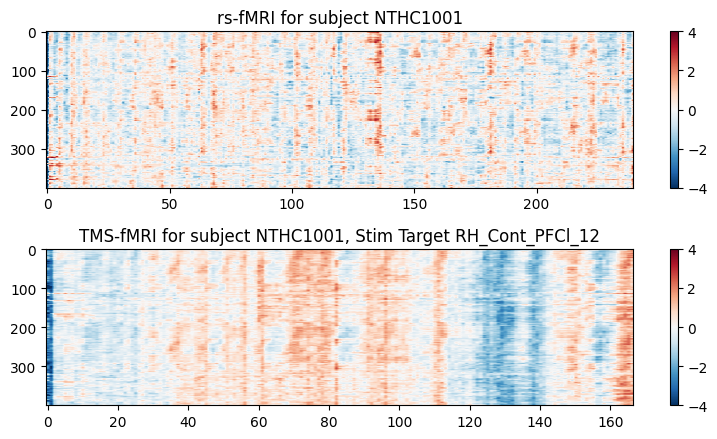

In [72]:
from scipy import stats
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4.5))
plt.subplot(2,1,1)
plt.title('rs-fMRI for subject %s'%subjects_all[sid])
plt.imshow(stats.zscore(rest_ex).T, 
           aspect='auto',cmap='RdBu_r',vmax=4,vmin=-4)
plt.colorbar()
plt.subplot(2,1,2)
plt.title('TMS-fMRI for subject %s, Stim Target %s'%(subjects_all[sid],target_label))
plt.imshow(stats.zscore(task_ex).T, 
           aspect='auto',cmap='RdBu_r',vmax=4,vmin=-4)
plt.colorbar()
plt.tight_layout()
plt.show()

# CHECK ALIGNMENT PARCELS

In [41]:
import os, glob, re
from nilearn.image import load_img, index_img, resample_to_img
from nilearn import plotting

# =========================
# CONFIG
# =========================
BASE_DIR   = "/Volumes/LaCie2/fufo/data/Interim/MSCA/TMS_fMRI"
DERIV_DIR  = os.path.join(BASE_DIR, "derivatives")
SUBJECTS_TXT = os.path.join(BASE_DIR, "subjects_all.txt")
ATLAS_PATH = os.path.join(BASE_DIR, "Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz")

# =========================
# LOAD SUBJECT LIST
# =========================
with open(SUBJECTS_TXT, "r") as f:
    subjects_all = [ln.strip() for ln in f if ln.strip() and not ln.strip().startswith("#")]

# subjects_all contains like: ["NTHC1001", "NTHC1002", ...]
# We will internally map -> "sub-NTHC1001"
def to_bids_sub_id(sub_name):
    return sub_name if sub_name.startswith("sub-") else f"sub-{sub_name}"

# =========================
# FIND BOLD AUTOMATICALLY
# =========================
def find_bold_auto(sub_name, task="task-rest"):
    """
    sub_name: "NTHC1001" (from subjects_all) or "sub-NTHC1001"
    task: "task-rest" or "task-stim"
    Returns: (bold_path, ses_id, stim_coords_or_None)
    """
    sub_id = to_bids_sub_id(sub_name)
    sub_dir = os.path.join(DERIV_DIR, sub_id)
    if not os.path.isdir(sub_dir):
        raise FileNotFoundError(f"Subject folder not found: {sub_dir}")

    # Search all sessions/func for matching preproc BOLDs
    patt = os.path.join(
        sub_dir, "ses-*", "func",
        f"*{task}*_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"
    )
    hits = sorted(glob.glob(patt))
    if not hits:
        raise FileNotFoundError(f"No BOLD files found for {sub_id} with task={task}\nPattern:\n{patt}")

    bold_path = hits[0]  # choose first match (usually only one per task/session)
    ses_id = os.path.basename(os.path.dirname(os.path.dirname(bold_path)))  # .../ses-*/func/file.nii.gz -> ses-*

    stim_coords = None
    if task == "task-stim":
        fname = os.path.basename(bold_path)
        m = re.search(r"task-stim(\-?\d+)x(\-?\d+)x(\-?\d+)", fname)
        if m:
            stim_coords = tuple(map(int, m.groups()))
        else:
            stim_coords = None

    return bold_path, ses_id, stim_coords

# =========================
# PLOT ALIGNMENT
# =========================
def plot_alignment_auto(
    sub_name,
    task="task-rest",
    alpha_parcels=0.6,
    display_mode="ortho",
    cut_coords=(0, 0, 0),
    show_contours=True
):
    """
    sub_name: e.g. subjects_all[0] -> "NTHC1001"
    task: "task-rest" or "task-stim"
    Automatically finds session + (if stim) parses MNI coords from filename and puts in title.
    """
    bold_path, ses_id, stim_coords = find_bold_auto(sub_name, task=task)

    # Load BOLD (first volume)
    bold_4d = load_img(bold_path)
    bold_3d = index_img(bold_4d, 0)

    # Load + resample atlas to BOLD grid
    atlas = load_img(ATLAS_PATH)
    atlas_rs = resample_to_img(atlas, bold_3d, interpolation="nearest")

    # Build title
    sub_id = to_bids_sub_id(sub_name)
    if task == "task-stim":
        stim_str = f" | stim @ MNI {stim_coords}" if stim_coords is not None else " | stim (coords not parsed)"
    else:
        stim_str = ""

    title = f"{sub_id} | {ses_id} | {task}{stim_str}\nfirst volume: {os.path.basename(bold_path)}"

    # Plot BOLD grayscale
    disp = plotting.plot_epi(
        bold_3d,
        cmap="gray",
        title=title,
        display_mode=display_mode,
        cut_coords=cut_coords,
        colorbar=False
    )

    # Overlay parcels categorical colors
    disp.add_overlay(
        atlas_rs,
        cmap="tab20",
        alpha=alpha_parcels,
        colorbar=False
    )

    # Optional parcel boundaries
    if show_contours:
        disp.add_contours(
            atlas_rs,
            levels=[0.5],
            colors="black",
            linewidths=0.5
        )

    plotting.show()

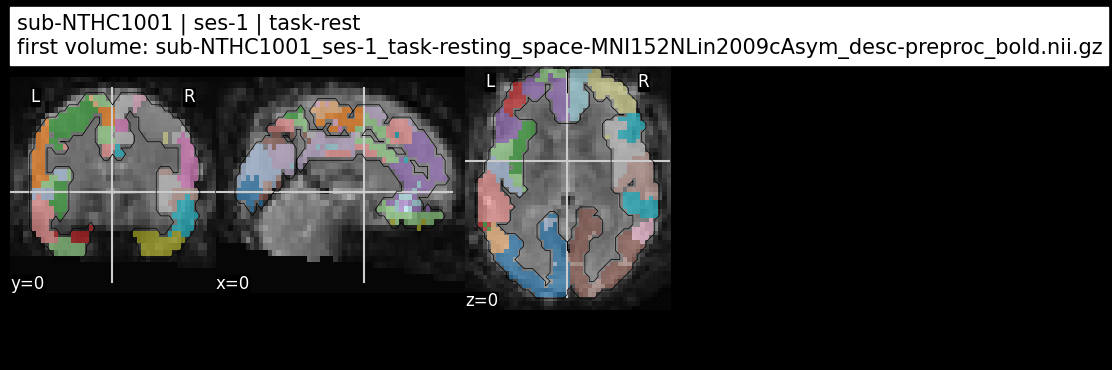

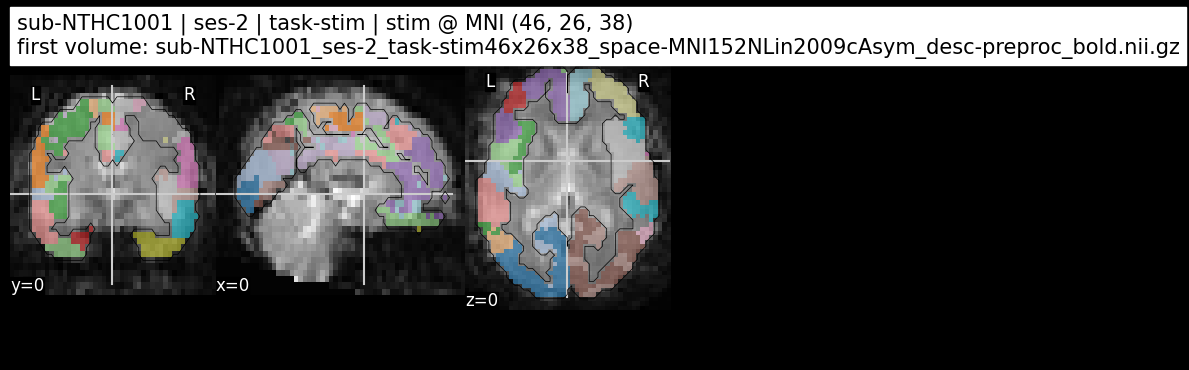

In [45]:
# =========================
# EXAMPLES
# =========================
plot_alignment_auto(subjects_all[0], task="task-rest", cut_coords=(0,0,0))
plot_alignment_auto(subjects_all[0], task="task-stim", cut_coords=(0,0,0))


# OLD CODE 

In [ ]:
# --- Setup cell ---

# 1 - Mount Drive (for data only)
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# 2 - Clone repo (only if missing)
import os
if not os.path.exists("/content/BrainStim_ANN_fMRI_HCP"):
    !git clone https://github.com/grabuffo/BrainStim_ANN_fMRI_HCP.git
else:
    print("Repo already exists ✅")

# 3 - Set paths
repo_dir = "/content/BrainStim_ANN_fMRI_HCP"
data_dir = "/content/drive/MyDrive/Colab Notebooks/Brain_Stim_ANN/data"

import sys
sys.path.append(repo_dir)

# 4 - Imports
from src.preprocessing_hcp import *
from src.NPI import *

import numpy as np
import matplotlib.pyplot as plt
import h5py
import gc

print("✅ Environment ready!")
print("Repo directory:", repo_dir)
print("Data directory:", data_dir)

Mounted at /content/drive
Repo already exists ✅
✅ Environment ready!
Repo directory: /content/BrainStim_ANN_fMRI_HCP
Data directory: /content/drive/MyDrive/Colab Notebooks/Brain_Stim_ANN/data


In [ ]:
# --- Preprocessing and data extraction ---

# Parameters
n_nodes = 450                # number of brain regions (parcels)
remove_points = 30           # remove first 30 TRs
using_steps = 3              # window length for multi2one
number_of_subjects = 10      # or 996 if all subjects
dtype = np.float32

# ------------------------------------------------------------------------------
# 1 - Locate fMRI run files
# ------------------------------------------------------------------------------

run_files = {
    "REST1_LR": os.path.join(data_dir, "fmri/Schaefer2018_400Parcels_7Networks_order_Tian_Subcortex_S3_REST1_LR.mat"),
    "REST1_RL": os.path.join(data_dir, "fmri/Schaefer2018_400Parcels_7Networks_order_Tian_Subcortex_S3_REST1_RL.mat"),
    "REST2_LR": os.path.join(data_dir, "fmri/Schaefer2018_400Parcels_7Networks_order_Tian_Subcortex_S3_REST2_LR.mat"),
    "REST2_RL": os.path.join(data_dir, "fmri/Schaefer2018_400Parcels_7Networks_order_Tian_Subcortex_S3_REST2_RL.mat")
}
run_order = list(run_files.keys())

print(f"✅ Found {len(run_files)} fMRI runs:")
for k in run_order:
    print("  -", k)

✅ Found 4 fMRI runs:
  - REST1_LR
  - REST1_RL
  - REST2_LR
  - REST2_RL


In [ ]:
# ------------------------------------------------------------------------------
# 2 - Find common subjects across runs
# ------------------------------------------------------------------------------

def list_subjects(h5path, run_key):
    """Return list of subjects for a given run file."""
    with h5py.File(h5path, "r") as f:
        return sorted(f["HCP"][run_key].keys(), key=lambda k: int(k.split("_")[-1]))

subject_sets = [set(list_subjects(run_files[k], k)) for k in run_order]
subject_ids = sorted(set.intersection(*subject_sets), key=lambda k: int(k.split("_")[-1]))

print(f"\n✅ Found {len(subject_ids)} subjects present in all runs.")
subject_ids = subject_ids[:number_of_subjects]
print(f"   → Will process first {len(subject_ids)} subjects.\n")


✅ Found 996 subjects present in all runs.
   → Will process first 10 subjects.



In [ ]:
# ------------------------------------------------------------------------------
# 3 - Process each subject
# ------------------------------------------------------------------------------

save_dir = os.path.join(data_dir, "preprocessed_subjects")
os.makedirs(save_dir, exist_ok=True)

for sid in subject_ids:
    print(f"🚀 Processing subject {sid}")
    subj_runs = []

    for run_key in run_order:
        # Load fMRI time series (T, N)
        with h5py.File(run_files[run_key], "r") as f:
            ts = f["HCP"][run_key][sid]["ts"][()]

        # Print shape before and after possible transpose
        print(f"      Original shape for {run_key}: {ts.shape}", end="")
        if ts.shape[0] < ts.shape[1]:
            ts = ts.T
            print(f" → Transposed to {ts.shape}")
        else:
            print(" (kept as is)")

        # Remove first 30 time points
        ts = ts[remove_points:, :n_nodes]

        # Apply bandpass filtering
        ts_filt = bandpass_filter_timeseries(ts)
        subj_runs.append(ts_filt)

        # Free memory from this run
        del ts, ts_filt
        gc.collect()

    # Concatenate all runs → (T_total, N)
    signals = np.concatenate(subj_runs, axis=0)
    print(f"   → Signals shape: {signals.shape}")

    # Create inputs and targets
    inputs, targets = multi2one(signals, steps=using_steps)
    print(f"   → Inputs: {inputs.shape}, Targets: {targets.shape}")

    # Save to disk
    np.save(os.path.join(save_dir, f"{sid}_signals.npy"), signals)
    np.save(os.path.join(save_dir, f"{sid}_inputs.npy"), inputs)
    np.save(os.path.join(save_dir, f"{sid}_targets.npy"), targets)
    print(f"   ✅ Saved preprocessed data for {sid}\n")

    # Cleanup
    del subj_runs, signals, inputs, targets
    gc.collect()

print("🎯 All subjects processed successfully!")
print(f"📂 Saved results in: {save_dir}")

🚀 Processing subject id_100206
      Original shape for REST1_LR: (1200, 450) (kept as is)
      Original shape for REST1_RL: (1200, 450) (kept as is)
      Original shape for REST2_LR: (1200, 450) (kept as is)
      Original shape for REST2_RL: (1200, 450) (kept as is)
   → Signals shape: (4680, 450)
   → Inputs: (4677, 1350), Targets: (4677, 450)
   ✅ Saved preprocessed data for id_100206

🚀 Processing subject id_100307
      Original shape for REST1_LR: (1200, 450) (kept as is)
      Original shape for REST1_RL: (1200, 450) (kept as is)
      Original shape for REST2_LR: (1200, 450) (kept as is)
      Original shape for REST2_RL: (1200, 450) (kept as is)
   → Signals shape: (4680, 450)
   → Inputs: (4677, 1350), Targets: (4677, 450)
   ✅ Saved preprocessed data for id_100307

🚀 Processing subject id_100408
      Original shape for REST1_LR: (1200, 450) (kept as is)
      Original shape for REST1_RL: (1200, 450) (kept as is)
      Original shape for REST2_LR: (1200, 450) (kept as is)

### Understanding `signals`, `inputs`, and `targets`

Let **T** = total number of time points and **S** = number of past steps.

---

**`signals`**  
- Shape: **(T, N)**  
- Preprocessed fMRI time series (after removing first 30 TRs, filtering, and concatenating runs).  
- `signals[t, n]` = BOLD activity of region *n* at time *t*.

---

**`inputs`**  
- Shape: **(T − S, N × S)**  
- Each row contains the flattened activity of all N regions over the past S time points.  
- Represents the temporal context used for prediction.

---

**`targets`**  
- Shape: **(T − S, N)**  
- Each row is the brain activity at the next time point following the input window.  
- What the model aims to predict.
